# Самостоятельный проект. Обучение с учителем: качество модели
### Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

### Описание данных
Данные для работы находятся в нескольких таблицах.
- market_file.csv
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
    - id — номер покупателя в корпоративной базе данных.
    - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    - Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
    - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    - Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
    - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    - Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    - Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
    - Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
    - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
    - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
- market_money.csv
    Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
    - id — номер покупателя в корпоративной базе данных.
    - Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    - Выручка — сумма выручки за период.
- market_time.csv
    Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
    - id — номер покупателя в корпоративной базе данных.
    - Период — название периода, во время которого зафиксировано общее время.
    - минут — значение времени, проведённого на сайте, в минутах.
- money.csv
    Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
    - id — номер покупателя в корпоративной базе данных.
    - Прибыль — значение прибыли.


# Оглавление <a class="anchor" id="toc"></a>
* [Шаг 1. Загрузка данных](#chapter1)
* [Шаг 2. Предобработка данных](#chapter2)
* [Шаг 3. Исследовательский анализ данных](#chapter3)
* [Шаг 4. Объединение таблиц](#chapter4)
* [Шаг 5. Корреляционный анализ](#chapter5)
* [Шаг 6. Использование пайплайнов](#chapter6)
* [Шаг 7. Анализ важности признаков](#chapter7)
* [Шаг 8. Сегментация покупателей](#chapter8)
* [Шаг 9. Общий вывод](#chapter9)

## Шаг 1. Загрузка данных <a class="anchor" id="chapter1"></a>
[К оглавлению](#toc)

In [ ]:
!pip install shap -q
!pip install scikit-learn==1.1.3 -q
!pip install phik -q
import shap
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from phik import phik_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder, QuantileTransformer, RobustScaler
from sklearn.metrics import (accuracy_score, recall_score, precision_score, roc_auc_score)
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import warnings

RANDOM_STATE = 42

In [2]:
sklearn.__version__

'1.1.3'

In [3]:
try:
    market_df = pd.read_csv('market_file.csv')
except:
    market_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')

market_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
try:
    market_money_df = pd.read_csv('market_money.csv')
except:
    market_money_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')

market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
try:
    market_time_df = pd.read_csv('market_time.csv')
except:
    market_time_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')

market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
try:
    money_df = pd.read_csv('money.csv', sep = ';', decimal = ',')
except:
    money_df = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal = ',')
money_df.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


## Шаг 2. Предобработка данных <a class="anchor" id="chapter2"></a>
[К оглавлению](#toc)

Проверим данные на пропуски

In [7]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Пропуски не обнаружены, проверим явные дубликаты: 

In [11]:
market_df.duplicated().sum()

0

In [12]:
market_money_df.duplicated().sum()

0

In [13]:
market_time_df.duplicated().sum()

0

In [14]:
money_df.duplicated().sum()

0

Проверим неявные дубликаты:

In [15]:
for column_name in market_df.select_dtypes(include=['object']).columns:
    print(column_name)
    print(market_df[column_name].unique())
    print('\n')

Покупательская активность
['Снизилась' 'Прежний уровень']


Тип сервиса
['премиум' 'стандартт' 'стандарт']


Разрешить сообщать
['да' 'нет']


Популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']




In [16]:
for column_name in market_money_df.select_dtypes(include=['object']).columns:
    print(column_name)
    print(market_money_df[column_name].unique())
    print('\n')

Период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']




In [17]:
for column_name in market_time_df.select_dtypes(include=['object']).columns:
    print(column_name)
    print(market_time_df[column_name].unique())
    print('\n')

Период
['текущий_месяц' 'предыдцщий_месяц']




In [18]:
for column_name in money_df.select_dtypes(include=['object']).columns:
    print(column_name)
    print(money_df[column_name].unique())
    print('\n')

Есть ошибки в market_df и в market_time_df, исправим:

In [19]:
market_df['Тип сервиса'] = market_df['Тип сервиса'].replace(['стандартт'],'стандарт')
market_df['Популярная_категория'] = market_df['Популярная_категория'].replace(['Косметика и аксесуары'],'Косметика и аксесcуары')
market_time_df['Период'] = market_time_df['Период'].replace(['предыдцщий_месяц'],'предыдущий_месяц')

Для дальнейших шагов поменяем название колонок:

In [20]:
market_df.columns = map(str.lower, market_df.columns)
market_df.columns = market_df.columns.str.replace(' ', '_')

market_money_df.columns = map(str.lower, market_money_df.columns)
market_money_df.columns = market_money_df.columns.str.replace(' ', '_')

market_time_df.columns = map(str.lower, market_time_df.columns)
market_time_df.columns = market_time_df.columns.str.replace(' ', '_')

money_df.columns = map(str.lower, money_df.columns)
money_df.columns = money_df.columns.str.replace(' ', '_')

In [21]:
market_money_df.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Для дальнейшего использования нам будет удобнее для каждого пользователя иметь сразу данные по всем периодам в одной строке

In [22]:
market_money_df = market_money_df.pivot_table(index='id',
                                             columns='период',
                                             values='выручка')
market_money_df.head()

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [23]:
market_time_df.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


Для дальнейшего использования нам будет удобнее для каждого пользователя иметь сразу данные по всем периодам в одной строке

In [24]:
market_time_df = market_time_df.pivot_table(index='id',
                                             columns='период',
                                             values='минут')
market_time_df.head()

период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


### Выводы по предобработке
- В данных не обнаружено пропусков
- В данных не обнаружено явных дубликатов
- В данных были обнаружены неявные дубликаты и ошибки в названиях, они были исправлены
- Названия колонок были исправлены
- Для дальнейшего удобства мы преобразовали таблицы market_money_df и market_time_df

## Шаг 3. Исследовательский анализ данных <a class="anchor" id="chapter3"></a>
[К оглавлению](#toc)

### market_df

In [25]:
market_df.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


- Явных аномалий или необъяснимых выбросов в данных нет
- Интересно, что есть пользователи, у которых 99% покупок было по акции, и что их скорее всего немного (75-й процентиль это 30% покупок, а максимум уже 99%)
- В среднем пользователи сталкиваются с 4 ошибками при том, что посещают 8 страниц

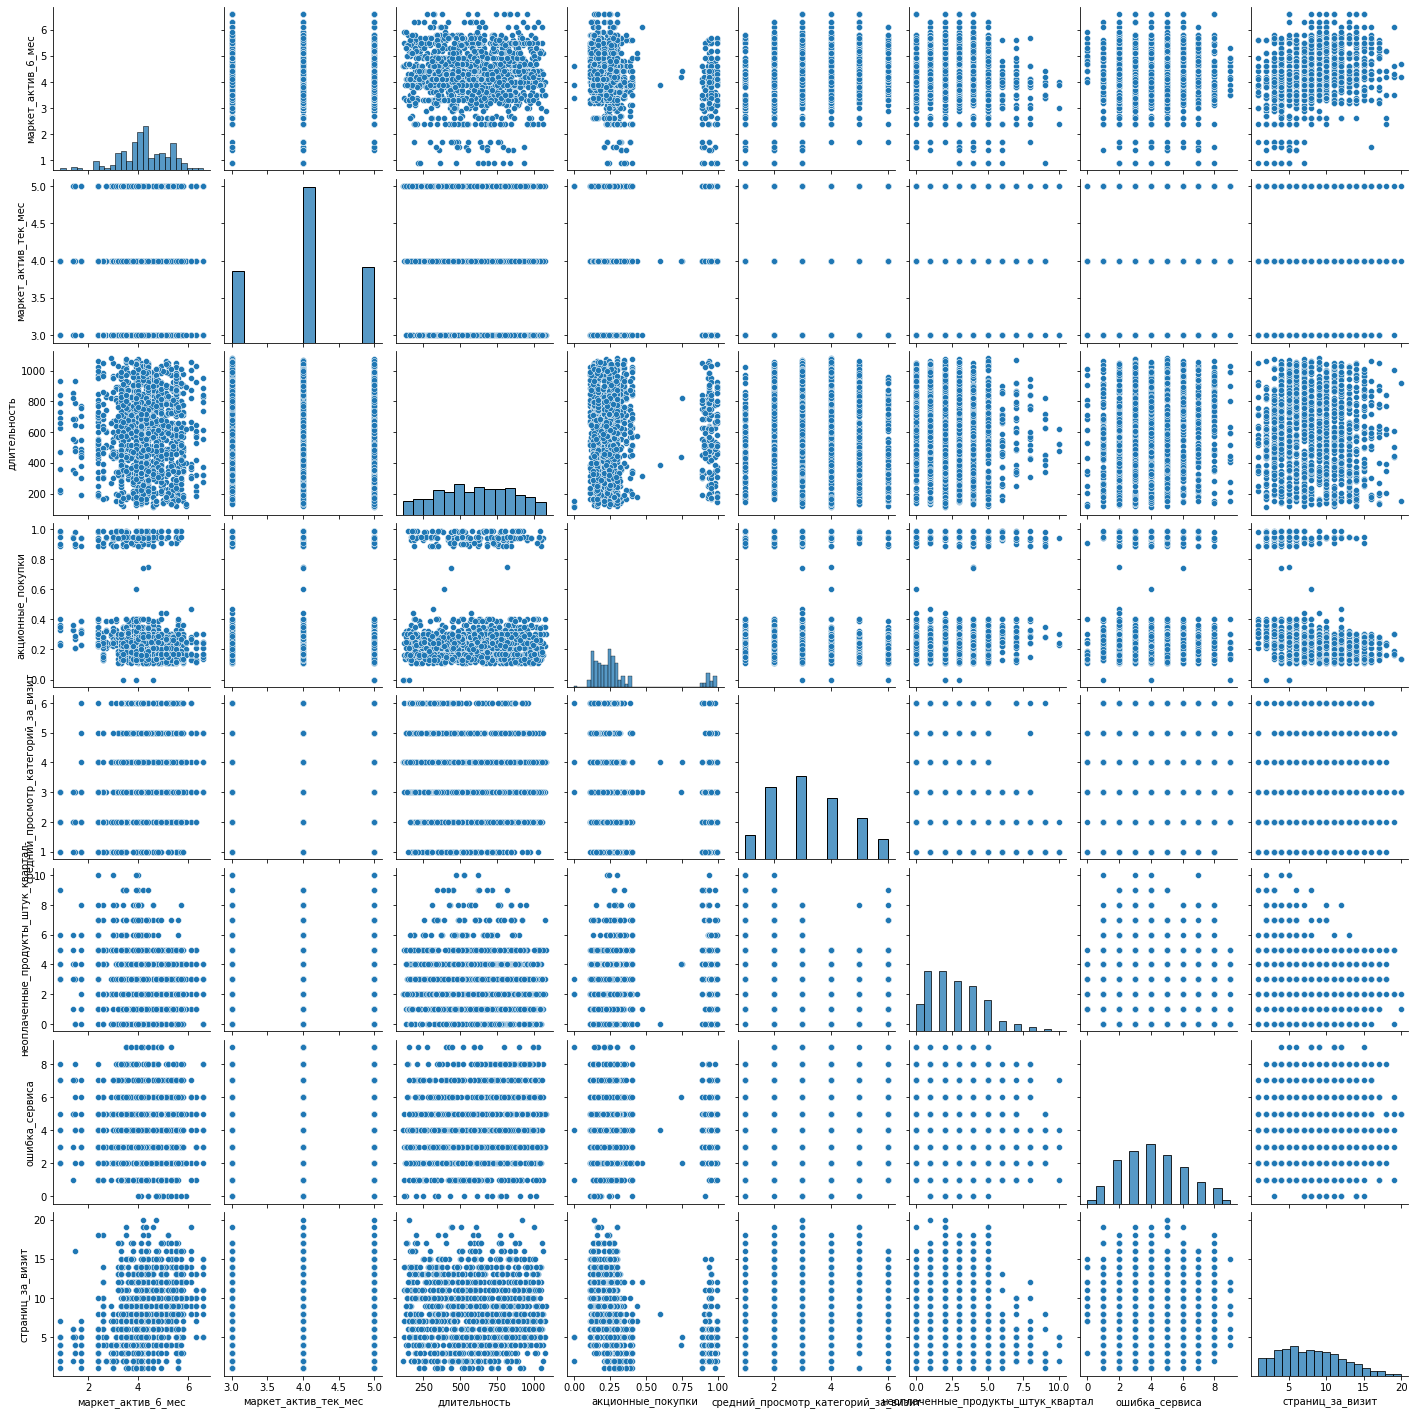

In [26]:
sns.pairplot(market_df.drop('id', axis = 1));

Из интересного: 
- Количество ошибок в сервисе имеет центр не в 0 или 1, а в 4
- В доле акционных покупок явно есть два кластера - те, кто приобретает всё вне зависимости от акций и те, кто их выжидает

In [27]:
num_col_market = ['маркет_актив_6_мес',
                  'маркет_актив_тек_мес',
                  'длительность',
                  'акционные_покупки',
                  'средний_просмотр_категорий_за_визит',
                  'неоплаченные_продукты_штук_квартал',
                  'ошибка_сервиса',
                  'страниц_за_визит']

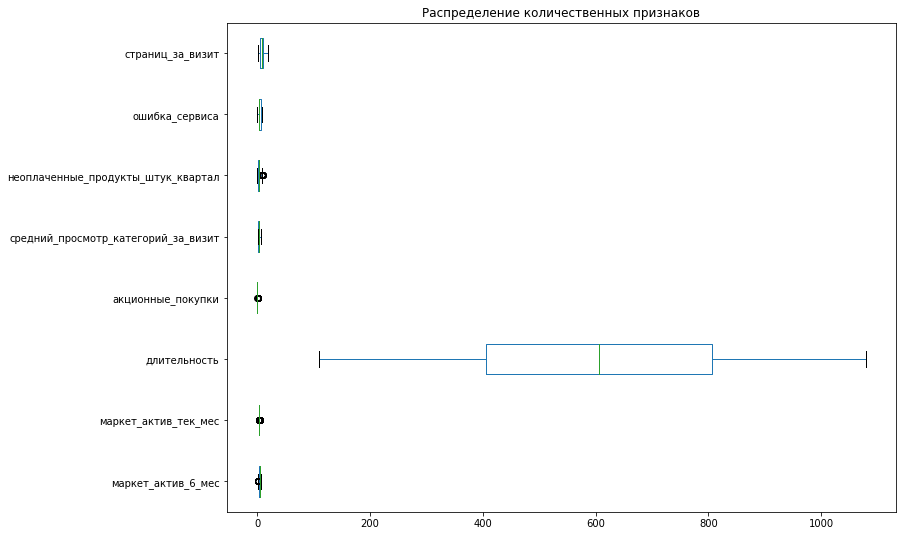

In [28]:
market_df[num_col_market].plot(kind='box',
                               title='Распределение количественных признаков',
                               xlabel='Значения признаков',
                               figsize=(12, 9),
                               vert=False);

Шкала длительности слишком большая в сравнении с другими полями, посмотрим на диаграмму без неё:

In [29]:
num_col_market_new = ['маркет_актив_6_мес',
                  'маркет_актив_тек_мес',
                  'акционные_покупки',
                  'средний_просмотр_категорий_за_визит',
                  'неоплаченные_продукты_штук_квартал',
                  'ошибка_сервиса',
                  'страниц_за_визит']

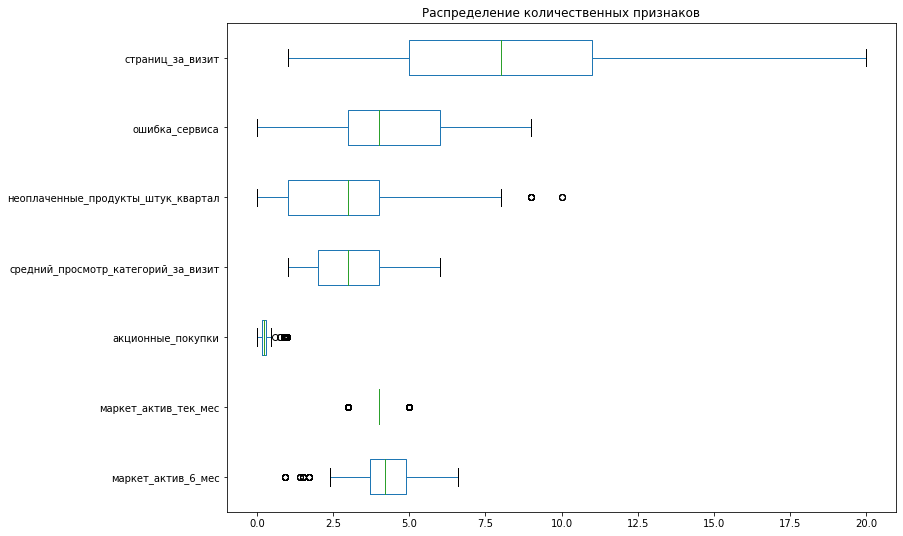

In [30]:
market_df[num_col_market_new].plot(kind='box',
                               title='Распределение количественных признаков',
                               xlabel='Значения признаков',
                               figsize=(12, 9),
                               vert=False);

- Из всех полей самый большой разброс у "страниц за визит"
- В акционных покупках выбросы - это отдельный кластер
- Есть малоактивные пользователи, это выбросы "слева" в "маркет_актив_6_мес"

In [31]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [32]:
cat_col_market = ['покупательская_активность',
                  'тип_сервиса',
                  'разрешить_сообщать',
                  'популярная_категория']

In [33]:
market_df[cat_col_market].describe()

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
count,1300,1300,1300,1300
unique,2,2,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,924,962,330


Большинство покупателей сохраняют прежний уровень активности, пользуются стандартным сервисом, дали согласие на рассылку, а самая популярная категория у них это "Товары для детей"

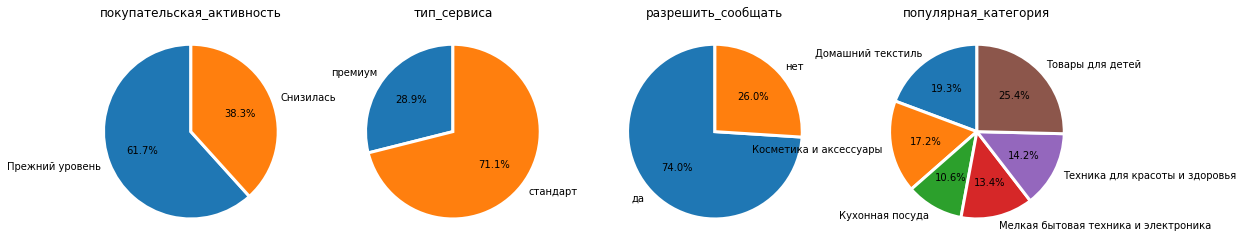

In [34]:
i = 1
plt.figure(figsize=(18,9))
for name in cat_col_market:
    plt.subplot(1, len(cat_col_market), i)
    plt.title(name)

    counts = market_df.groupby(name)['id'].count()
    labels = counts.index

    plt.pie(x=counts,
            startangle=90,
            labeldistance=1.1,
            wedgeprops={'linewidth':3, 'edgecolor':'white'},
            autopct='%1.1f%%',
            labels=labels)
    i += 1

- 61,7% пользователей сохранили покупательскую активность на прежнем уровне
- Премиум купили только 28,9% пользователей
- Разрешили сообщать предложения 74% пользователей
- Среди категорий нет значительного переверса, они занимают по 10-25%.

Отдельно посмотрим на связи с целевой переменной

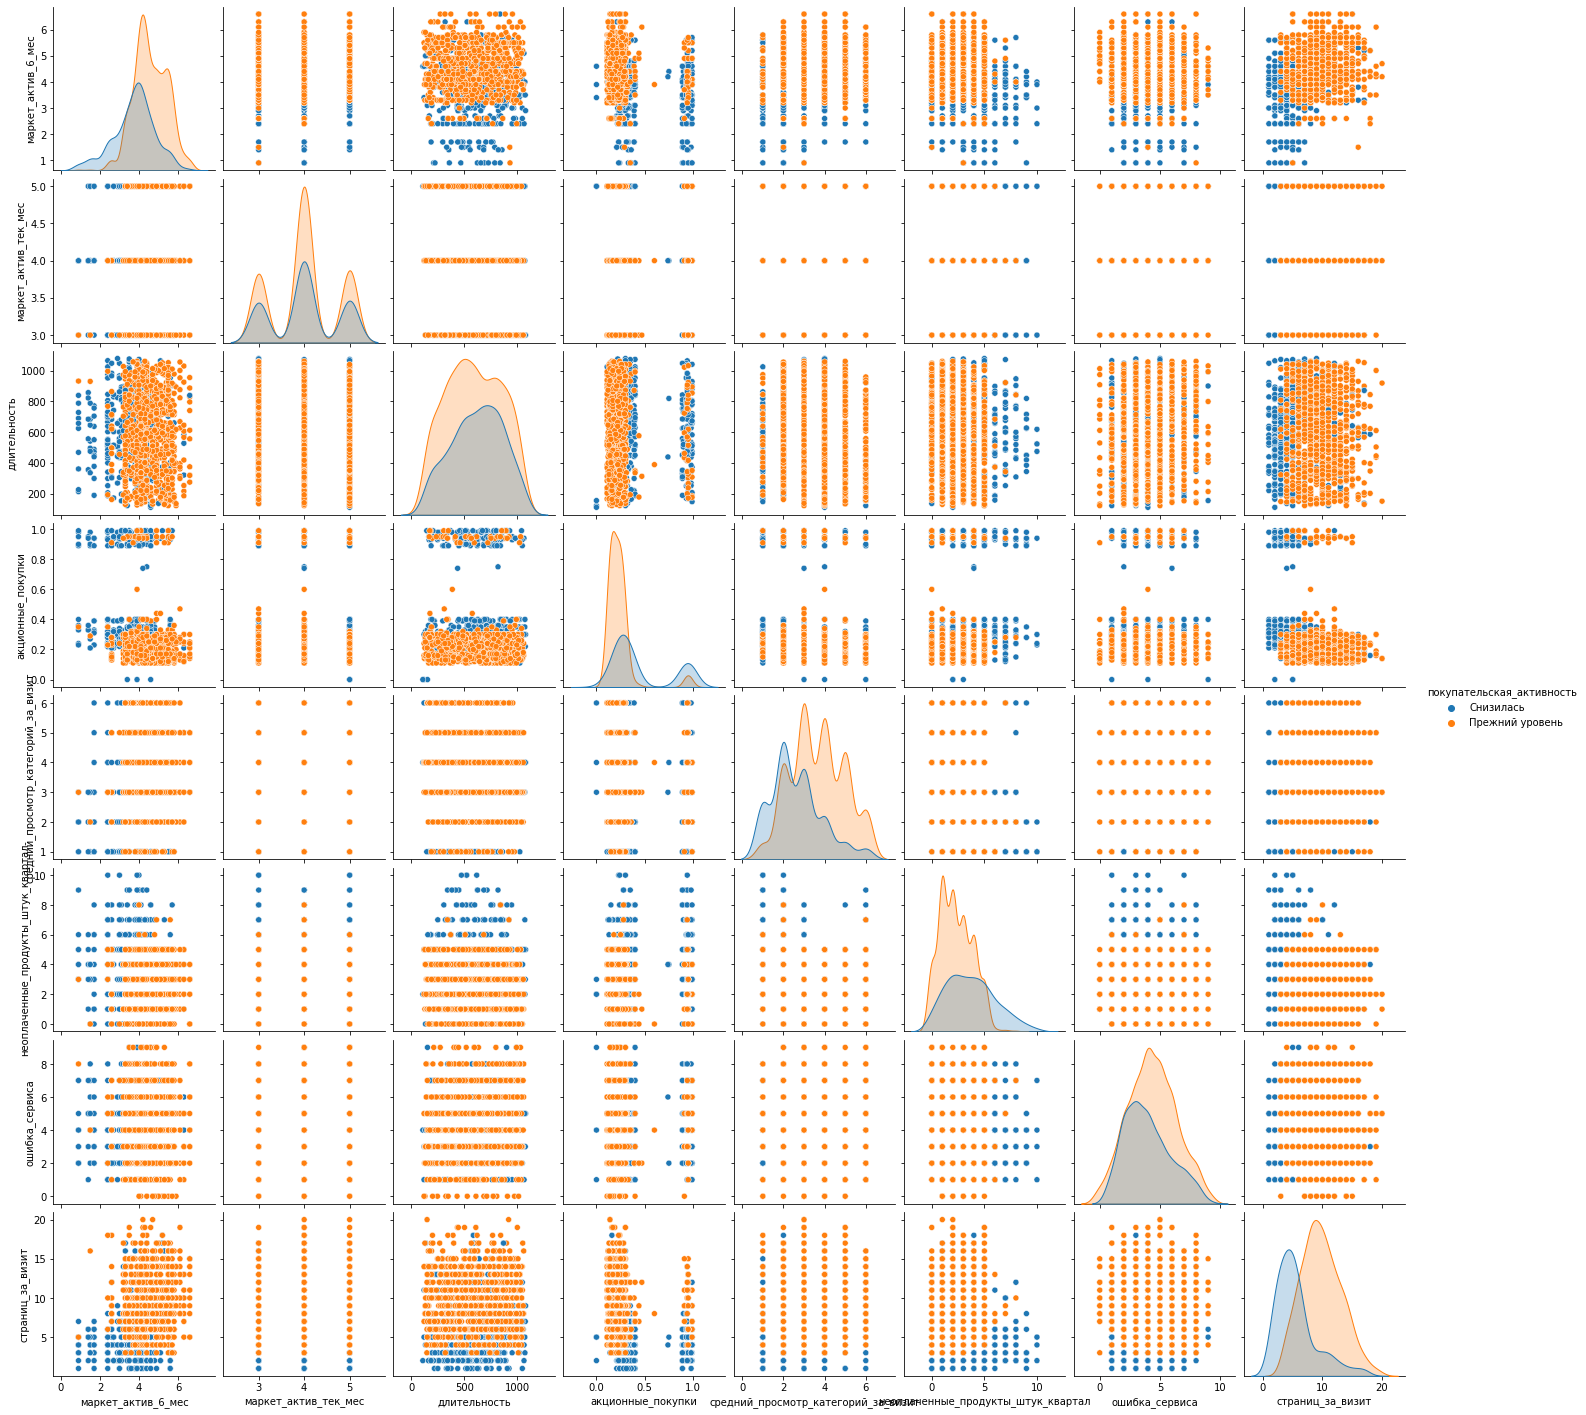

In [35]:
warnings.filterwarnings('ignore')
sns.pairplot(market_df.drop('id', axis = 1),
             hue = 'покупательская_активность');

Менее активные пользователи посещают в среднем меньше страниц за визит, смотрят меньше категорий, чаще оставляют товары в корзине, чаще совершают аукционные покупки (возможно, добавляют товар в корзину и следят за стоимостью).

### market_money_df

In [36]:
market_money_df.describe()

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
count,1300.000000,1300.000000,1300.000000
mean,4936.920385,4825.206923,5314.960846
std,739.597997,405.979663,2939.708156
min,0.000000,0.000000,2758.700000
25%,4496.750000,4583.000000,4706.050000
50%,5005.000000,4809.000000,5179.950000
75%,5405.625000,5053.500000,5761.725000
max,6869.500000,5663.000000,106862.200000


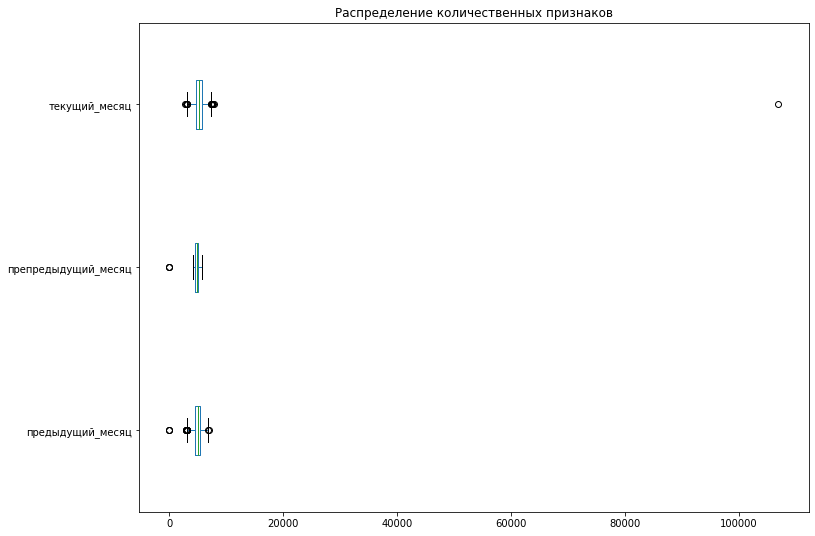

In [37]:
market_money_df.plot(kind='box',
                               title='Распределение количественных признаков',
                               xlabel='Значения признаков',
                               figsize=(12, 9),
                               vert=False);

В текущем месяце есть явный выброс. Удалим его, так как это может сказаться на качестве нашей модели - судя по всему, это нетипичное поведение (в предыдущих периодах таких выбросов нет)

In [38]:
market_money_df = market_money_df[market_money_df['текущий_месяц'] < market_money_df['текущий_месяц'].max()]

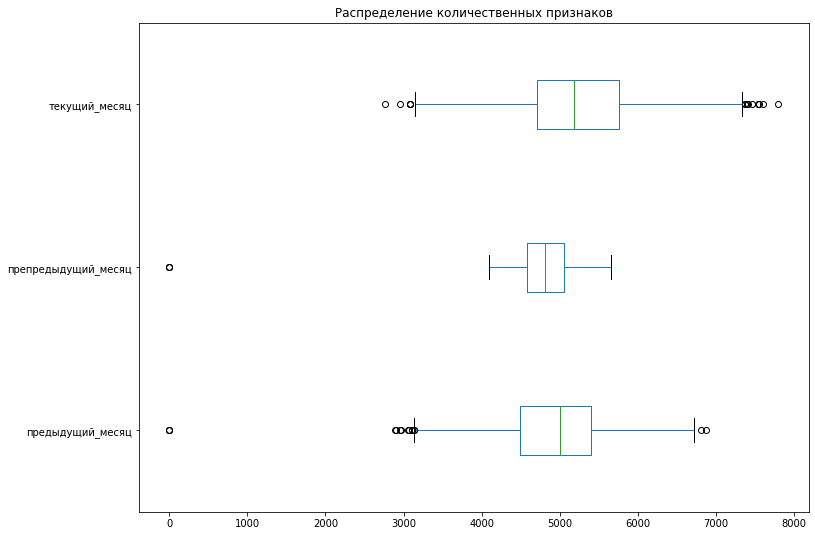

In [39]:
market_money_df.plot(kind='box',
                               title='Распределение количественных признаков',
                               xlabel='Значения признаков',
                               figsize=(12, 9),
                               vert=False);

У нас есть пользователи, которые не делали покупок в предыдущие периоды, нужно их изучить

In [40]:
market_money_df[(market_money_df['препредыдущий_месяц']==0) | (market_money_df['предыдущий_месяц']==0)]

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215357,0.0,0.0,5986.3
215359,0.0,0.0,4735.0


Это новые пользователи без покупательской истории, по условию задания нам надо их исключить

In [41]:
market_money_df = market_money_df[market_money_df['предыдущий_месяц'] > 0]

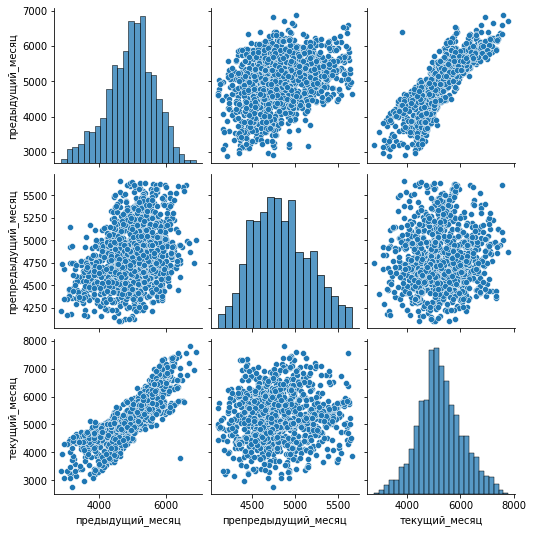

In [42]:
warnings.filterwarnings('ignore')

sns.pairplot(market_money_df);

- По нижней строке мы можем понять, что связь покупок в текущем месяце значительно сильнее, чем с покупками в месяц до этого
- Но интересно, что и предыдущий период не так сильно связан с предпредыдущим, как с текущим

### market_time_df

In [43]:
market_time_df.describe()

период,предыдущий_месяц,текущий_месяц
count,1300.000000,1300.000000
mean,13.467692,13.204615
std,3.932029,4.220589
min,5.000000,4.000000
25%,11.000000,10.000000
50%,13.000000,13.000000
75%,17.000000,16.000000
max,23.000000,23.000000


Аномального значения времени нет, данные за разные периоды очень похожи между собой

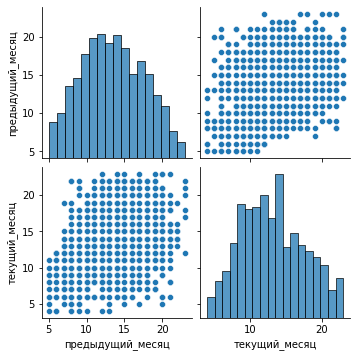

In [44]:
sns.pairplot(market_time_df);

Диаграммы подтверждают предыдущие выводы

### money_df

In [45]:
money_df['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

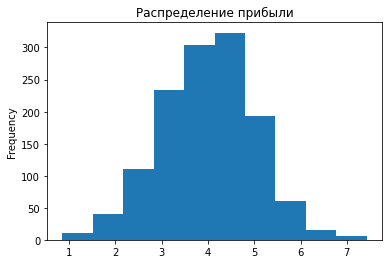

In [46]:
money_df['прибыль'].plot(kind='hist', title='Распределение прибыли');

Каких-то странностей и аномалий не обнаружено

## Шаг 4. Объединение таблиц <a class="anchor" id="chapter4"></a>
[К оглавлению](#toc)

In [47]:
market_df.set_index('id', inplace=True)

In [48]:
df = (market_df
      .join(market_money_df,
                     how='inner',
                     lsuffix='',
                     rsuffix='_выручка')
      .join(market_time_df,
                     how='inner',
                     lsuffix='',
                     rsuffix='_время')
     )
df.rename(columns = {'предыдyщий_месяц': 'предыдущий_месяц_время'}, inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Проблем при объединении таблиц не возникло

## Шаг 5. Корреляционный анализ <a class="anchor" id="chapter5"></a>
[К оглавлению](#toc)

Поскольку у нас в данных есть столбцы, в которых точно не нормальное распределение (как минимум, те же акционные покупки), то используем коэффициент Спирмена.

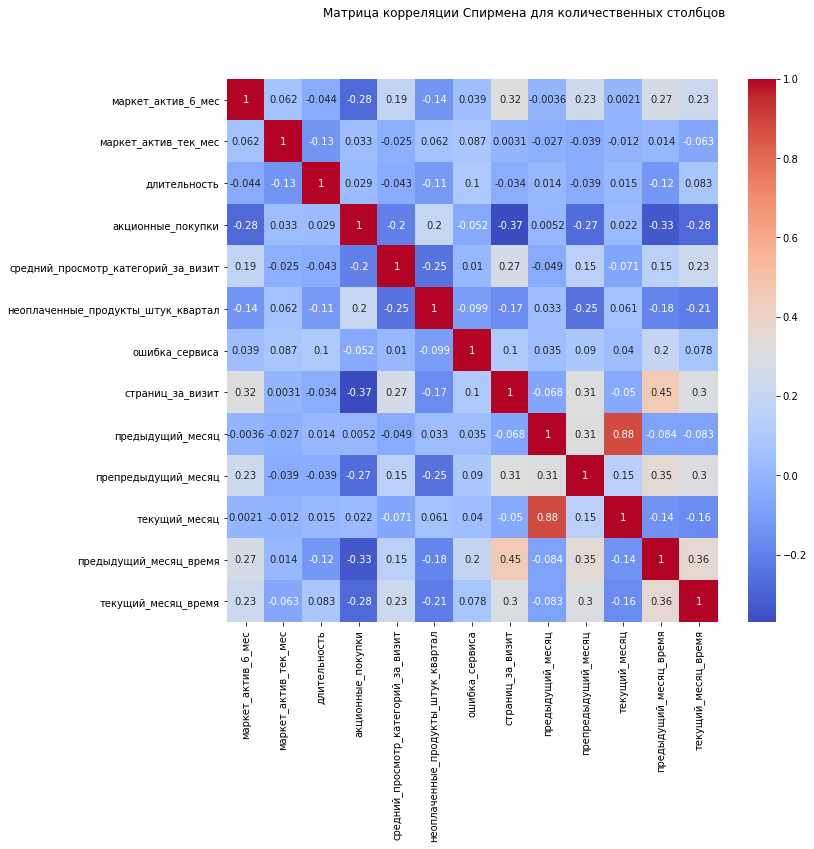

In [51]:
# Выбираем только числовые столбцы
numeric_df = df.select_dtypes(include=['number'])

fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции Спирмена для количественных столбцов')
sns.heatmap(numeric_df.corr(method="spearman"), annot=True, cmap='coolwarm', ax=ax)
plt.show()

Есть сильная корреляция между выручкой в предыдущий и в текущий месяц, также есть средняя корреляция между количеством страниц за визит и временем в предыдущем и текущем месяцах. Как ни странно, время в предыдущем и в текущем месяце связано не слишком сильно.

Посмотрим на корреляцию phi(k)

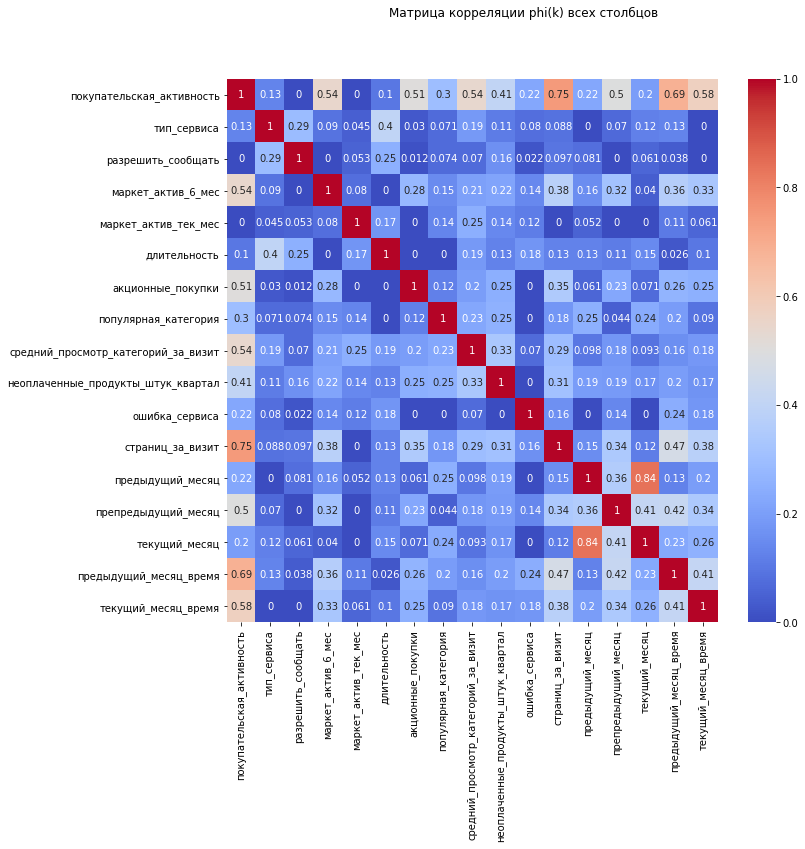

In [52]:
interval_cols = ['препредыдущий_месяц',
                  'предыдущий_месяц',
                  'текущий_месяц',
                  'предыдущий_месяц_время',
                  'текущий_месяц_время',
                 'маркет_актив_6_мес',
                 'длительность',
                 'акционные_покупки'
                ]
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

### Вывод по корреляционному анализу

Покупательская активность сильно коррелирует с:
1) Количеством страниц за визит (0,75)
2) Временем в предыдущем месяце (0,69)
3) Временем в текущем месяце (0,58)
4) Маркетинговой активностью за 6 месяцев (0,54)
5) Средним просмотром категорий за визит (0,54)
6) С активностью в предыдущих периодах

## Шаг 6. Использование пайплайнов <a class="anchor" id="chapter6"></a>
[К оглавлению](#toc)

In [53]:
X = df.drop(['покупательская_активность'], axis=1)
y = df['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify = y)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

le = LabelEncoder()
le.fit(y_train.unique())
print ('Значениям', le.classes_, 'назначены', le.transform(le.classes_))
y_train = le.transform(y_train)
y_test = le.transform(y_test)

(972, 16)

(324, 16)

(972,)

(324,)

Значениям ['Прежний уровень' 'Снизилась'] назначены [0 1]


In [54]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
num_columns = X_train.select_dtypes(['int64', 'float64']).columns.to_list()

In [55]:
# Пайплайн для заполнения пропусков и OHE колонок из ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

In [56]:
# Пайплайн для заполнения пропусков и SimpleImputer из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['да', 'нет'],
                    
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord',
      SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [57]:
# Общий пайплайн
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [58]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [59]:
param_grid = {
    'preprocessor': [data_preprocessor],
    'models': [
        DecisionTreeClassifier(random_state=42),
        KNeighborsClassifier(),
        SVC(random_state=42, probability=True),
        LogisticRegression(random_state=42)
    ]
}

В качестве метрики возьмём ROC-AUC
- Метрика универсальная, позволяет сравнивать модели между собой
- Устойчива к дисбалансам, а у нас есть несбалансированные классы
- Вместо сравнения с конкретным значением мы можем увидеть баланс между ошибками и верными определениями

Поиск без перебора гиперпараметров

In [60]:
grid = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [61]:
grid.fit(X_train, y_train)

print(grid.best_params_)

{'models': SVC(probability=True, random_state=42), 'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['популярная_категория']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categor...
                                 ['тип_сервиса', 'разреш

In [62]:
print('ROC-AUC лучшей модели: ', round(grid.best_score_, 4))

ROC-AUC лучшей модели:  0.9084


In [63]:
param_choice = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe, ord_pipe],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe, ord_pipe],
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe, ord_pipe],
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe, ord_pipe],
    }
]

Поиск перебором гиперпараметров

In [64]:
grid_1 = GridSearchCV(
    pipe_final,
    param_grid=param_choice,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
)
warnings.filterwarnings('ignore')
grid_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['популярная_категория']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImpu...
                                                                 OneHotEncoder(drop='first',
                                                                               handle_unknown='ignore'))]),
                                                Pipeline(steps=[('simpleImputer_before_ord',
                                                                 SimpleImputer(strategy='most_frequent')),
                                                                ('ord',
                                                                 OrdinalEncoder(categories=[['стандарт',
                                                                                             'премиум'],
                                                                                            ['да',
                                                                                             'нет']],
                                                                                handle_unknown='use_encoded_value',
                                                                                unknown_value=nan)),
                                                                ('simpleImputer_after_ord',
                                                                 SimpleImputer(strategy='most_frequent'))])]}],
             scoring='roc_auc')

In [65]:
print(grid_1.best_estimator_)
print('ROC-AUC лучшей модели: ', round(grid_1.best_score_, 4))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent'...
                                    

In [66]:
y_pred = grid.predict_proba(X_test)
print(f'ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred[:, 1]), 4)}')

ROC-AUC на тестовой выборке: 0.9124


### Выводы по шагу
- Удалось выбрать лучшую модель (SVM)
- На тренировочной выборке выбранная нами метрика ROC-AUC была 0.9. На тестовой 0,91.

## Шаг 7. Анализ важности признаков <a class="anchor" id="chapter7"></a>
[К оглавлению](#toc)

In [67]:
X_encoded = grid.best_estimator_['preprocessor'].fit_transform(X_train)
model = grid.best_estimator_['models'].fit(X_encoded, y_train)

background = shap.sample(X_encoded, 100)  # Выборка для ускорения работы эксплейнера
explainer = shap.KernelExplainer(model.predict, background)
shap_values = explainer.shap_values(background)

labels = grid.best_estimator_[:-1].get_feature_names_out()

  0%|          | 0/100 [00:00<?, ?it/s]

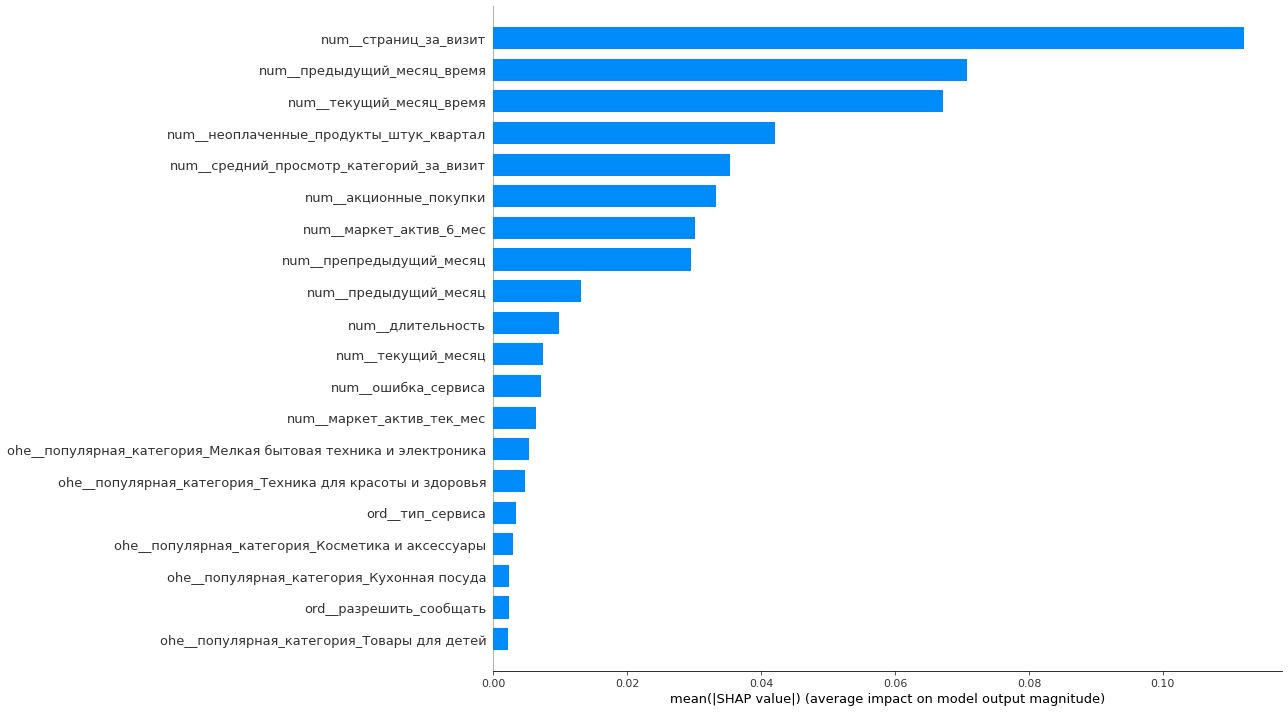

In [68]:
shap.summary_plot(shap_values, X_encoded, plot_type='bar', feature_names=labels, plot_size=(18, 10))

### Вывод по шагу
1) Самые важные признаки в целом совпадают с результатами корреляционного анализа и имеют логичное объяснение.
2) Для модели оказались не важны категории, тип сервиса и разрешение на получение рекламных акций

Из этого можно сделать вывод, что маркетинговая активность, на которую мы влияем, важна для изменения покупательской активности, в то время как тип сервиса и разрешение на получение акций нам не так важны для этой цели.

## Шаг 8. Сегментация покупателей <a class="anchor" id="chapter8"></a>
[К оглавлению](#toc)

Из предложенных сегментов мной был выбран "Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью."
Нацелимся на удержание пользователей: постараемся предсказать снижение активности, чтобы его предотвратить

In [69]:
money_df.set_index('id', inplace=True)
result_df = df.join(money_df,
                    how='inner',
                    lsuffix='',
                    rsuffix='')

In [70]:
result_df['предсказанная_активность'] = (
    le.inverse_transform(
        grid.predict(
            result_df.drop(
                columns = ['покупательская_активность', 'прибыль']
            )
        )
    )
)

Используем закон Парето: предположим, что у нас есть 20% покупателей, приносящих нам 80% прибыли. Нужно их удержать, чтобы не потерять прибыль от этого сегмента.

In [71]:
result_df = result_df.sort_values(by='прибыль', ascending = False)

result_df['Накопленная доля прибыли'] = result_df['прибыль'].cumsum() / result_df['прибыль'].sum()

presorted_df = result_df[(result_df['Накопленная доля прибыли'] <= 0.8)]

sorted_df = presorted_df[(presorted_df['предсказанная_активность'] == 'Снизилась')]

print('Доля от количества покупателей: ', presorted_df.shape[0] / result_df.shape[0])
print('Доля от общей прибыли: ', presorted_df['прибыль'].sum() / result_df['прибыль'].sum())
print('Покупателей в сегменте: ', presorted_df.shape[0])
print('Покупателей с риском уменьшения активности: ', sorted_df.shape[0])


Доля от количества покупателей:  0.7121913580246914
Доля от общей прибыли:  0.7999100563209562
Покупателей в сегменте:  923
Покупателей с риском уменьшения активности:  291


На самом деле, у нас не наблюдается закон Парето: 80% прибыли нам приносит 71% покупателей. Треть из них может снизить активность, будем изучать их.

In [72]:
sorted_df.columns

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц',
       'текущий_месяц', 'предыдущий_месяц_время', 'текущий_месяц_время',
       'прибыль', 'предсказанная_активность', 'Накопленная доля прибыли'],
      dtype='object')

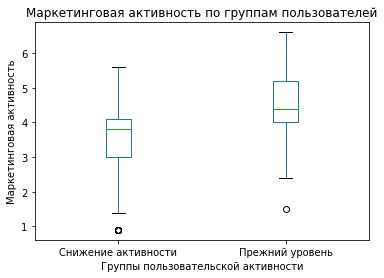

In [73]:
pd.DataFrame({'Снижение активности': sorted_df['маркет_актив_6_мес'],
             'Прежний уровень': presorted_df[presorted_df['предсказанная_активность'] == "Прежний уровень"]['маркет_актив_6_мес']})\
.plot(kind='box').set(title='Маркетинговая активность по группам пользователей',
                      xlabel='Группы пользовательской активности', ylabel='Маркетинговая активность');

Судя по графику, маркетинговая активность за 6 месяцев для пользователей со снижением активности действительно была меньше.

Рекомендация бизнеcу - делать дополнительную рекламную активность (рассылки, баннеры на сайте на их сегмент и т.д.) для пользователей из прибыльных сегментов, которых нужно удерживать.

### Сравним популярность категорий между собой

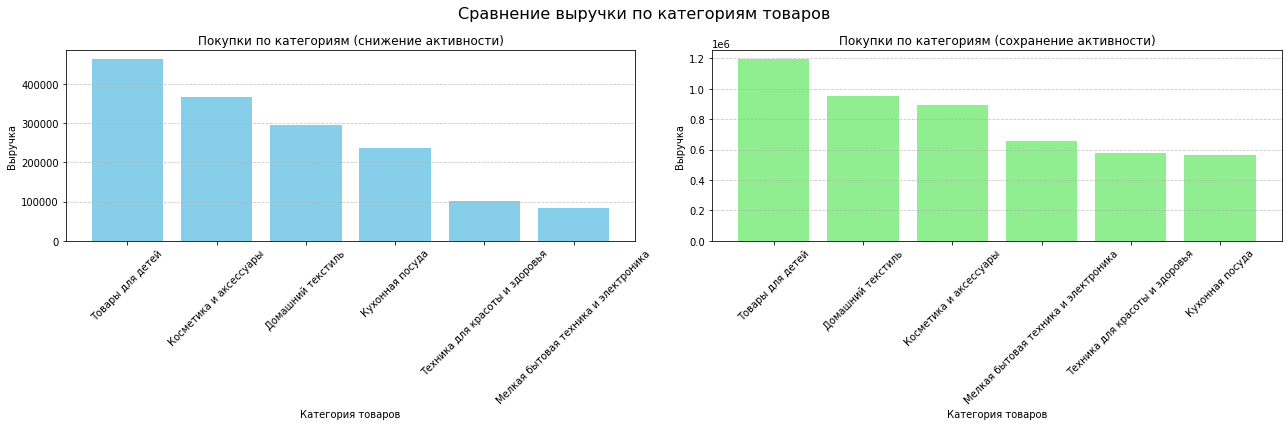

In [74]:
category_purchase_sorted = sorted_df.groupby('популярная_категория')['текущий_месяц'].sum().reset_index()
category_purchase_sorted = category_purchase_sorted.sort_values(by='текущий_месяц', ascending=False)

category_purchase_presorted = presorted_df.groupby('популярная_категория')['текущий_месяц'].sum().reset_index()
category_purchase_presorted = category_purchase_presorted.sort_values(by='текущий_месяц', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].bar(category_purchase_sorted['популярная_категория'], category_purchase_sorted['текущий_месяц'], color='skyblue')
axes[0].set_title('Покупки по категориям (снижение активности)')
axes[0].set_xlabel('Категория товаров')
axes[0].set_ylabel('Выручка')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(category_purchase_presorted['популярная_категория'], category_purchase_presorted['текущий_месяц'], color='lightgreen')
axes[1].set_title('Покупки по категориям (сохранение активности)')
axes[1].set_xlabel('Категория товаров')
axes[1].set_ylabel('Выручка')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle('Сравнение выручки по категориям товаров', fontsize=16)

plt.tight_layout()
plt.show()

Для пользователей, у которых прогнозируется снижение активности, самыми популярными категориями являются товары для детей, косметика и аксессуары, домашний текстиль, кухонная посуда, техника для красоты и здоровья, мелкая бытовая техника и электроника. В сохранении активности порядок категорий иной, хотя первая тройка такая же.

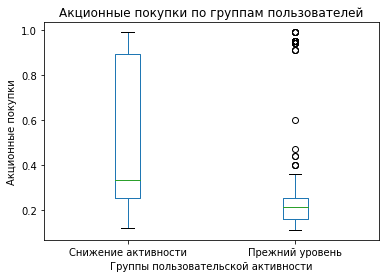

In [75]:
pd.DataFrame({'Снижение активности': sorted_df['акционные_покупки'],
             'Прежний уровень': presorted_df[presorted_df['предсказанная_активность'] == "Прежний уровень"]['акционные_покупки']})\
.plot(kind='box').set(title='Акционные покупки по группам пользователей',
                      xlabel='Группы пользовательской активности', ylabel='Акционные покупки');

In [76]:
sorted_df['акционные_покупки'].quantile([0.5, 0.75])

0.50    0.330
0.75    0.895
Name: акционные_покупки, dtype: float64

In [77]:
presorted_df['акционные_покупки'].quantile([0.5, 0.75])

0.50    0.24
0.75    0.30
Name: акционные_покупки, dtype: float64

Группа, которая может снизить активность, значительно больше покупает по акции, чем та, которая сохраняет активность. Медиана доли акционных покупок в этой группе - 33%. Из предварительного анализа мы выяснили, что по всем покупателям это выше, чем 75-й процентиль (0.3). В это же время в группе, где прогнозируется сохраненеие активности, 75-й процентиль тоже 0.3. Это означает, что снижение ожидается у покупателей, для которых важны акции.

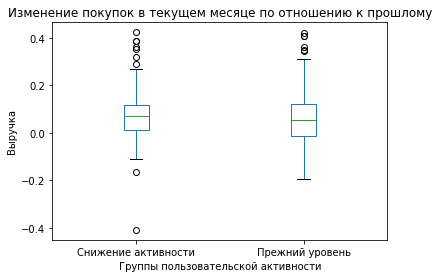

In [78]:
presorted_df['выручка_изменение'] = presorted_df['текущий_месяц'] / presorted_df['предыдущий_месяц'] - 1
sorted_df['выручка_изменение'] = sorted_df['текущий_месяц'] / sorted_df['предыдущий_месяц'] - 1

pd.DataFrame({'Снижение активности': sorted_df['выручка_изменение'],
             'Прежний уровень': presorted_df[presorted_df['предсказанная_активность'] == "Прежний уровень"]['выручка_изменение']})\
.plot(kind='box').set(title='Изменение покупок в текущем месяце по отношению к прошлому',
                      xlabel='Группы пользовательской активности', ylabel='Выручка');

Разницы в динамике покупок относительно предыдущего месяца нет

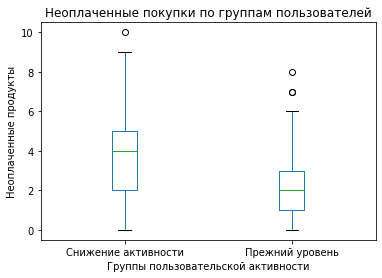

In [79]:
pd.DataFrame({'Снижение активности': sorted_df['неоплаченные_продукты_штук_квартал'],
             'Прежний уровень': presorted_df[presorted_df['предсказанная_активность'] == "Прежний уровень"]['неоплаченные_продукты_штук_квартал']})\
.plot(kind='box').set(title='Неоплаченные покупки по группам пользователей',
                      xlabel='Группы пользовательской активности', ylabel='Неоплаченные продукты');

У пользователей, по которым ожидается снижение активности, больше неоплаченных продуктов (медиана 4 против 2 с 75-м процентилем в 9). Зная, что это люди, которые чаще покупают товары по акции, вполне возможно, что они держат товары в корзине в ожидании акции.

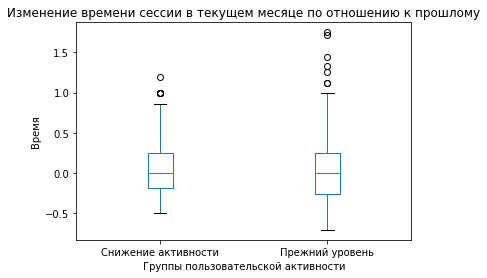

In [80]:
presorted_df['время_изменение'] = presorted_df['текущий_месяц_время'] / presorted_df['предыдущий_месяц_время'] - 1
sorted_df['время_изменение'] = sorted_df['текущий_месяц_время'] / sorted_df['предыдущий_месяц_время'] - 1

pd.DataFrame({'Снижение активности': sorted_df['время_изменение'],
             'Прежний уровень': presorted_df[presorted_df['предсказанная_активность'] == "Прежний уровень"]['время_изменение']})\
.plot(kind='box').set(title='Изменение времени сессии в текущем месяце по отношению к прошлому',
                      xlabel='Группы пользовательской активности', ylabel='Время');

Разницы в динамике длины сессии относительно предыдущего месяца нет

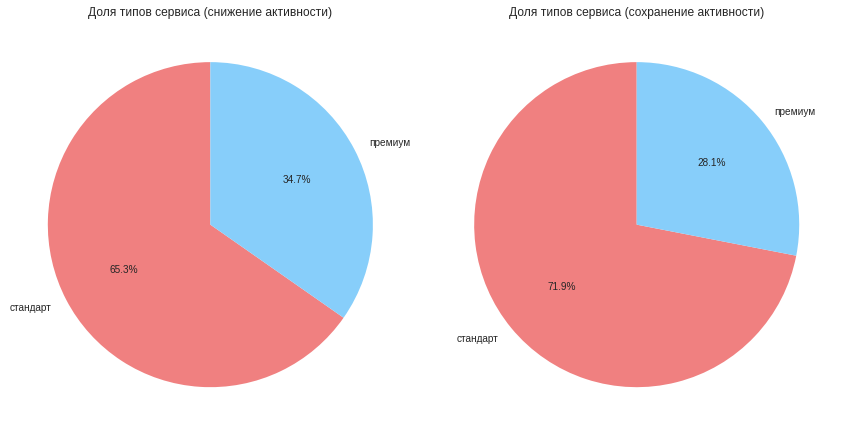

In [81]:
service_type_sorted = sorted_df['тип_сервиса'].value_counts()
service_type_result = presorted_df['тип_сервиса'].value_counts()

plt.style.use('seaborn')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(service_type_sorted, labels=service_type_sorted.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Доля типов сервиса (снижение активности)')

plt.subplot(1, 2, 2)
plt.pie(service_type_result, labels=service_type_result.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Доля типов сервиса (сохранение активности)')

plt.tight_layout()
plt.show()

В группе, в которой прогнозируется отток, доля премиума чуть выше, но такая разница скорее говорит о том, что снижение активности не связано с уровнем сервиса.

### Выводы по разделу
- На самом деле, у нас не наблюдается закон Парето: 80% прибыли нам приносит 71% покупателей. Треть из них может снизить активность.
- Для пользователей, у которых прогнозируется снижение активности, самыми популярными категориями являются товары для детей, косметика и аксессуары, домашний текстиль, кухонная посуда, техника для красоты и здоровья, мелкая бытовая техника и электроника. В сохранении активности порядок категорий иной, хотя первая тройка такая же.
- Группа, которая может снизить активность, значительно больше покупает по акции, чем та, которая сохраняет активность. Медиана доли акционных покупок в этой группе - 33%. Из предварительного анализа мы выяснили, что по всем покупателям это выше, чем 75-й процентиль (0.3). В это же время в группе, где прогнозируется сохраненеие активности, 75-й процентиль тоже 0.3. Это означает, что снижение ожидается у покупателей, для которых важны акции.
- Разницы в динамике покупок и длины сессии относительно предыдущего месяца нет
- У пользователей, по которым ожидается снижение активности, больше неоплаченных продуктов (медиана 4 против 2 с 75-м процентилем в 9). Зная, что это люди, которые чаще покупают товары по акции, вполне возможно, что они держат товары в корзине в ожидании акции.
- В группе, в которой прогнозируется отток, доля премиума чуть выше, но такая разница скорее говорит о том, что снижение активности не связано с уровнем сервиса.

**Рекомендации:**
- Сделать дополнительную рекламную активность (рассылки, баннеры на сайте на их сегмент и т.д.) для пользователей из прибыльных сегментов, которых нужно удерживать.
- Можно попробовать напомнить с помощью рассылки о товарах в корзине, оповестить о том, что их осталось немного и т.п.
- Возможно, изменения в активности этих пользователей связаны с запуском акций в магазине, и стоит отдельно обращать внимание на долю покупок по акции при изучении количества увеличивших и снизивших активность пользователей.

## Шаг 9. Общий вывод <a class="anchor" id="chapter9"></a>
[К оглавлению](#toc)

В результате выполнения проекта была создана модель для предсказания изменения покупательской активности в интернет-магазине "В один клик". Также был проведен анализ данных и сформулированы рекомендации.

### Предварительная обработка

- В данных не было обнаружено пропусков
- В данных не обнаружено явных дубликатов
- В данных были обнаружены неявные дубликаты и ошибки в названиях, они были исправлены
- Названия колонок были исправлены
- Для дальнейшего удобства мы преобразовали таблицы market_money_df и market_time_df

### Моделирование

- Лучшей моделью оказалась SVC (метод опорных векторов), показавшая значение метрики ROC AUC, равное 0.83.

### Анализ признаков

- Покупательская активность сильно коррелирует с:

    - Количеством страниц за визит (0,75)
    - Временем в предыдущем месяце (0,69)
    - Временем в текущем месяце (0,58)
    - Маркетинговой активностью за 6 месяцев (0,54)
    - Средним просмотром категорий за визит (0,54)
    - С активностью в предыдущих периодах

- Для модели оказались не важны категории, тип сервиса и разрешение на получение рекламных акций
- Из этого можно сделать вывод, что маркетинговая активность, на которую мы влияем, важна для изменения покупательской активности, в то время как тип сервиса и разрешение на получение акций нам не так важны для этой цели.

### Итоговые наблюдения и рекомендации
- Для сохранения прибыли был проанализирован сегмент покупателей, приносящих 80% прибыли и которые потенциально в будущем снизят пользовательскую активность
- **Рекомендации бизнесу**:
    - Сделать дополнительную рекламную активность (рассылки, баннеры на сайте на их сегмент и т.д.) для пользователей из прибыльных сегментов, которых нужно удерживать.
    - Можно попробовать напомнить с помощью рассылки о товарах в корзине, оповестить о том, что их осталось немного и т.п.
    - Возможно, изменения в активности этих пользователей связаны с запуском акций в магазине, и стоит отдельно обращать внимание на долю покупок по акции при изучении количества увеличивших и снизивших активность пользователей.